## 2)

> Rehacer el Problema 1) considerando ahora un flujo estratificado en la aproximación de Boussinesq.
Utilice el solver BOUSS de GHOST, nuevamente con condiciones iniciales nulas para el campo de velocidad,
con forzado mecánico aleatorio con amplitud `f0 = 0.75` centrado en los modos Fourier con $k$ entre $1$ y $4$
(i.e., `kdn = 1`, `kup = 4`)
con las mismas propiedades temporales que en el problema anterior (`rand=2`, `cort=0.5`),
y sin fluctuaciones iniciales en la temperatura y sin fuentes térmicas ($c0 = s0 = 0$).
Utilice
una frecuencia de Brunt-Väisälä $N = 8$,
viscosidad cinemática y difusividad térmica $ν = κ = 2 × 10^{−3}$ y
$192 × 192 × 48$ puntos de resolución espacial en un dominio cúbico con tamaño $2π × 2π × π/2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray
from ghost_xarray import open_dataarray
from common import Output


plt.rc("figure", dpi=100, figsize=(6, 3))

t_max = 25
Δt_save_spectrum = 0.5
Δt_save_field = 1.5

output = Output(
    "problema2/output/",
    dt=Δt_save_spectrum,
    balance=["time", "<v²>", "<ω²>", "mechanic injection rate"],
    helicity=["time", "kinetic helicity"],
    scalar=["time", "<θ²>", "<|∇θ|²>", "temperature injection rate"],
    kspectrum=["k", "Ev(k)"],
    kspecpara=["k", "Ev(kz)", "Ev_perp(kz)", "Ev_z(kz)"],
    kspecperp=["k", "Ev(kp)", "ev_x,y(kp,kz=0)", "ev_z(kp,kz=0)"],
)

> a) Compare las resoluciones espaciales $∆x$, $∆y$ y $∆z$ del problema con las del Problema 1).
¿Como justifica los cambios en el tamaño del dominio y en la resolución?

In [2]:
N = np.array([192, 192, 48])
Δx = 2 * np.pi * np.array([1, 1, 1/4]) / N

Δx_problema1 = 2 * np.pi / N
Δx / Δx_problema1

array([1.  , 1.  , 0.25])

El tamaño del dominio en la dirección $z$ se achicó en un factor 1/4 respecto el problema anterior.
Pero, ahora, la resolución espacial es igual en todas las direcciones.

In [3]:
Δx

array([0.03272492, 0.03272492, 0.03272492])

In [4]:
coords = {x: dx * np.arange(n) for x, dx, n in zip("xyz", Δx, N)}

> b) Grafique la energía cinética, la energía potencial, y el cociente entre ambas.
¿Como son las fluctuaciones térmicas comparadas con la velocidad?

In [5]:
data = output.load_global_output("balance", "scalar")[["<v²>", "<θ²>"]].assign(
    **{"<θ²>/<v²>": lambda x: x["<θ²>"] / x["<v²>"]}
)
data.head(2)

,<v²>,<θ²>,<θ²>/<v²>
time,,,
0.00,0.000000,0.000000,NaN
0.05,0.001216,0.000023,0.018603


array([<AxesSubplot: xlabel='time'>, <AxesSubplot: xlabel='time'>,
       <AxesSubplot: xlabel='time'>], dtype=object)

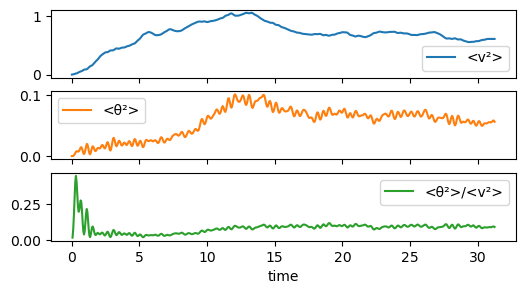

In [6]:
data.plot(subplots=True)

Luego de un transitorio,
la enegía cinética creoe mucho más rápido que la energía potencíal,
y se estabiliza alrededor de $t \sim 15$,
donde empieza etapa turbulenta.
En dicha etapa,
la relación entre ambas energías es del orden de $ \sim 10\%$.

In [7]:
data.loc[20:].describe()

,<v²>,<θ²>,<θ²>/<v²>
count,226.000000,226.000000,226.000000
mean,0.660667,0.063383,0.096078
std,0.054847,0.006738,0.008159
min,0.553294,0.049713,0.075083
25%,0.608588,0.057621,0.090510
50%,0.673928,0.064220,0.096255
75%,0.711357,0.068242,0.102427
max,0.733268,0.077732,0.113799


> c) Grafique el espectro de energía cinética isótropo $E(k)$,
el espectro de energía cinética perpendicular $E(k_⊥)$,
y el espectro de energía cinética paralelo $E(k_∥)$
promediados en el tiempo, para tiempos suficientemente tardíos.
Compare los espectros con las predicciones fenomenológicas.

In [8]:
data = output.load_output("kspectrum", "kspecperp")[["Ev(k)", "Ev(kp)"]]
data_para = output.load_output("kspecpara")["Ev(kz)"]

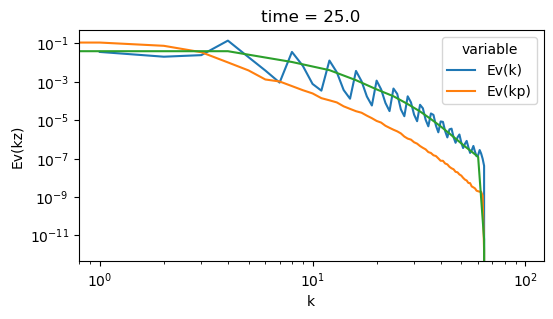

In [9]:
(
    data
    .isel(time=-1)
    .to_array()
    .plot.line(x="k", xscale="log", yscale="log")
)
data_para.isel(time=-1).plot.line(x="k", xscale="log", yscale="log");

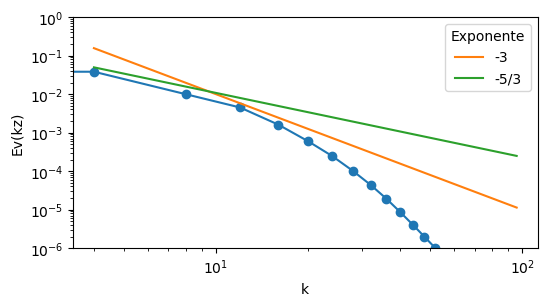

In [10]:
tmp = data_para.sel(time=slice(20, None)).mean("time")
tmp.plot.line(x="k", xscale="log", yscale="log", marker="o")
plt.ylim(1e-6, 1)

k = tmp.k
plt.plot(k, 10 * k**(-3), label="-3")
plt.plot(k, 0.5 * k**(-5/3), label="-5/3")
plt.legend(title="Exponente")

In [11]:
def fit_power_law(x):
    p, cov = np.polyfit(np.log(x.k), np.log(x), 1, cov=True)
    return pd.Series({"pendiente": p[0], "error": cov[0,0]**0.5})

pd.DataFrame({
    "inicio": fit_power_law(tmp.isel(k=slice(1, 4))),
    "medio": fit_power_law(tmp.isel(k=slice(4, 7))),
    "final": fit_power_law(tmp.isel(k=slice(8, 12))),
}).round(2)

,inicio,medio,final
pendiente,-1.95,-4.63,-7.51
error,0.00,0.13,0.17


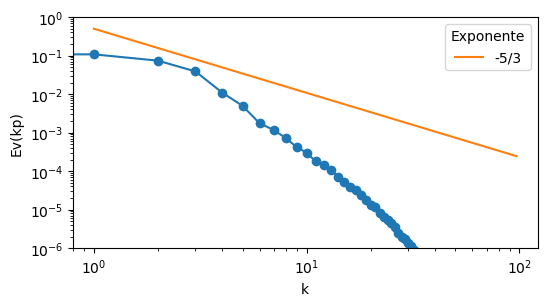

In [12]:
tmp = data["Ev(kp)"].sel(time=slice(20, None)).mean("time")
tmp.plot.line(x="k", xscale="log", yscale="log", marker="o")
plt.ylim(1e-6, 1)

k = tmp.k
plt.plot(k, 0.5 * k**(-5/3), label="-5/3")
plt.legend(title="Exponente")

In [13]:
def fit_power_law(x):
    p, cov = np.polyfit(np.log(x.k), np.log(x), 1, cov=True)
    return pd.Series({"pendiente": p[0], "error": cov[0,0]**0.5})

pd.DataFrame({
    "inicio": fit_power_law(tmp.sel(k=slice(5, 20))),
}).round(2)

,inicio
pendiente,-4.12
error,0.07


Para el espectro perpendicular,
esperabamos que el espectro siga una ley de potencias con exponente $k^{-5/3}$.
En cambio,
para el espectro paralelo,
esperabamos que siga dos leyes de ptencia:
$k^{-3}$ y $k^{-5/3}$,
para regiones por debajo y por encima del $k$ de Ozmidov,
respectivamente.
Esto no se observa en los gráficos de los espectros.

> d) Utilizando los espectros de energía calcule
la longitud integral isótropa $L$,
la longitud perpendicular $L_⊥$,
y la longitud paralela $L_∥$
en función del tiempo.
Calcule la longitud paralela obtenida por análisis dimensional
(la "longitud de empuje"), $L_B = 2π/k_B$ (con $k_B = N/U$, donde $U$ es la velocidad típica del fluido),
y compare esta longitud con la obtenida a partir del espectro, $L_∥$.
Utilizando estas longitudes estime el número de Reynolds y los números de Froude paralelo y perpendicular (puede asumir $U_⊥ ∼ U$).

In [14]:
U = 1
N = 8
nu = 2e-3
k_B = N / U
L_B = 2 * np.pi / k_B

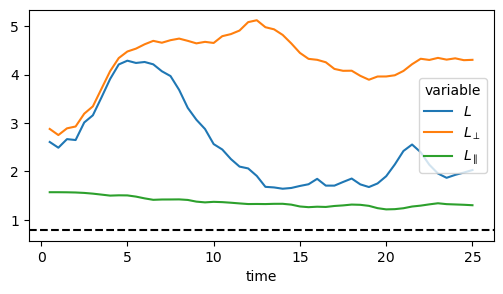

In [15]:
def longitud(E):
    E = E.isel(k=slice(1, None))  # saco k=0
    k = E.k
    L_medio = 2 * np.pi * (E / k).sum("k") / E.sum("k")
    return L_medio

data_L = data.groupby("time").map(longitud)
data_L["$L_\parallel$"] = data_para.groupby("time").map(longitud)
data_L.rename({"Ev(k)": "$L$", "Ev(kp)": "$L_\perp$"}).to_array().plot.line(x="time")
plt.axhline(L_B, label="$L_B$", color="black", linestyle="--")

El numero de Froude $F_r$ lo podemos calcular como:

$$ F_r = \frac{U}{N L} $$

In [16]:
def reynolds_number(U, L, nu):
    return U * L / nu


def froude_number(U, N, L):
    return U / (N * L)


L = {"parallel": 1.5, "perpendicular": 4.5}
pd.DataFrame(
    {
        orientation: dict(
            Reynolds=reynolds_number(U=1, L=Lo, nu=nu),
            Froude=froude_number(U=1, L=Lo, N=N),
        )
        for orientation, Lo in L.items()
    }
).round(3)

,parallel,perpendicular
Reynolds,750.000,2250.000
Froude,0.083,0.028


Basados en el número de Reynolds,
podemos decir que el sistema es más turbulento en la dirección perpendicular.
Por otro lado,
los números de Froude son menores a $1$,
que no se corresponde con los casos de fuerte o débil estratificación
\cite{Davidson, p. 443}.

> e) Para algún tiempo $t > t^*$,
grafique un corte de las fluctuaciones de temperatura $π$ en el plano $x − z$.
¿Qué observa? ¿Son compatibles las estructuras con lo que esperaba?

In [17]:
th = open_dataarray(
    output.path,
    "th",
    dt=1.5,
    shape=coords,
    dtype="float32",
)
th

<xarray.DataArray 'th' (t: 17, x: 192, y: 192, z: 48)>
dask.array<concatenate, shape=(17, 192, 192, 48), dtype=float32, chunksize=(1, 192, 192, 48), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0 0.03272 0.06545 0.09817 ... 6.152 6.185 6.218 6.25
  * y        (y) float64 0.0 0.03272 0.06545 0.09817 ... 6.152 6.185 6.218 6.25
  * z        (z) float64 0.0 0.03272 0.06545 0.09817 ... 1.44 1.473 1.505 1.538
  * t        (t) float64 0.0 1.5 3.0 4.5 6.0 7.5 ... 18.0 19.5 21.0 22.5 24.0

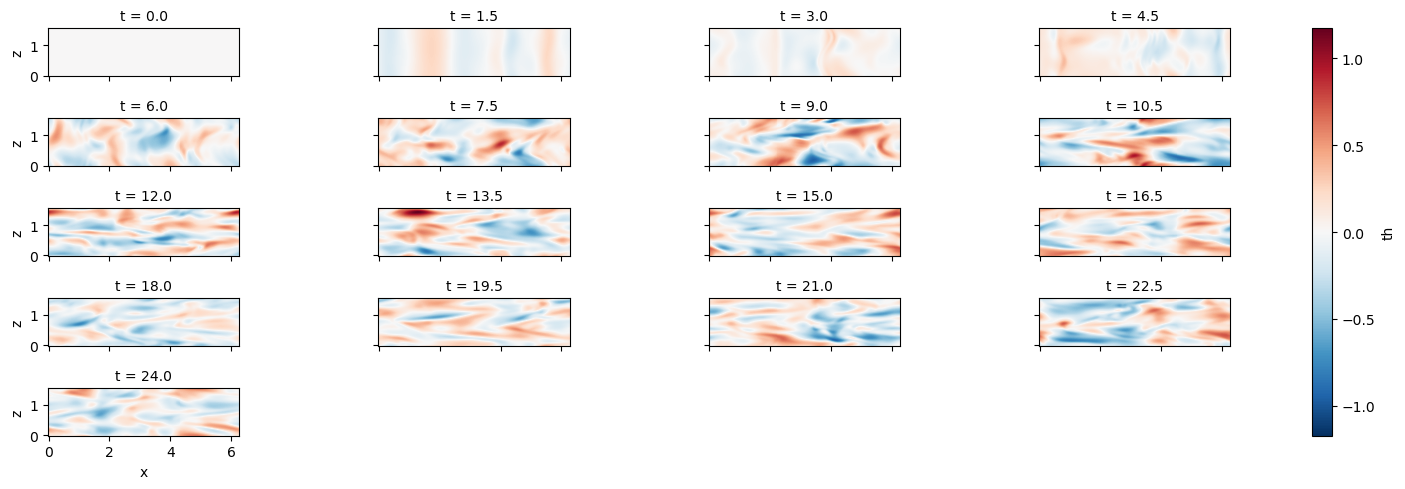

In [18]:
ax = (
    th
    .isel(y=96)
    # .sel(t=[10, 20], method="nearest")
    .plot(x="x", y="z", col="t", col_wrap=4, size=1, aspect=4)
)
for ax in ax.axes.flat:
    ax.set_aspect("equal")

A medida que se desarrolla la turbulencia,
se observan estructuras alargadas en la dirección perpendicular.
Estas se mantienen incluso para $t$ grandes,
por lo que el sistema no llega a una etapa de turbulencia isótropa.